## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json',)# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [5]:
#Assign new column names
df.rename(columns=lambda x: x.replace('_source.', ''), inplace=True)
df.rename(columns=lambda x: x.strip('_'), inplace=True)
print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [6]:
#Assign nan in place of blanks in the complaints column
df[df['complaint_what_happened']==''] = np.nan

In [7]:
#Remove all rows where complaints column is nan
print(df.complaint_what_happened.isna().sum())
df = df[~df.complaint_what_happened.isna()]
print(df.complaint_what_happened.isna().sum())

57241
0


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [8]:
import regex as re
#nltk libraries
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\balaji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\balaji\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\balaji\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    
    #Make the text lowercase
    text = text.lower()
    #Remove text in square brackets
    text = re.sub("\[\s*\w*\s*\]", "", text)
     # Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation]) 
    # remove numbers.
    text = re.sub(r'\d+', '', text)
    
    return text    

In [10]:
df.complaint_what_happened = df.complaint_what_happened.apply(lambda complaint: clean_text(complaint))

In [11]:
#Write your function to Lemmatize the texts
stop_words = set(stopwords.words('english'))
def lemmatizer(text):       
     # tokenize into words
    words = word_tokenize(text)

    # remove stop words and lemmatize
    words = [wordnet_lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # join words to make sentence
    return " ".join(words)

In [12]:
df["complaint_lemma"] = df.complaint_what_happened.apply(lambda complaint : lemmatizer(complaint))

In [13]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[["complaint_what_happened", "complaint_lemma"]]

In [14]:
df_clean.head()

,complaint_what_happened,complaint_lemma
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...


In [15]:
# shorten the pipline loading
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])

#Write your function to extract the POS tags 
def extract_pos(text):
    doc = nlp(text)
    pos_list = []
    for tok in doc:
        if(tok.tag_ =='NN'):
            pos_list.append(tok.text.lower())
        
    return " ".join(pos_list)

In [16]:
df_clean["complaint_pos_removed"] =  df_clean.complaint_what_happened.apply(lambda complaint: extract_pos(complaint))

C:\Users\balaji\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_lemma,complaint_pos_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx card agent anniversary date agent informa...
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,application identity consent credit identity a...
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx xxxx xxxx ticket offer ticket card inform...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...
...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade credit chase bonus ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,xxxx xxxx visa credit card provider claim purc...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk chase bank app chase banking merchant...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit chase credit chase freedom balance life...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




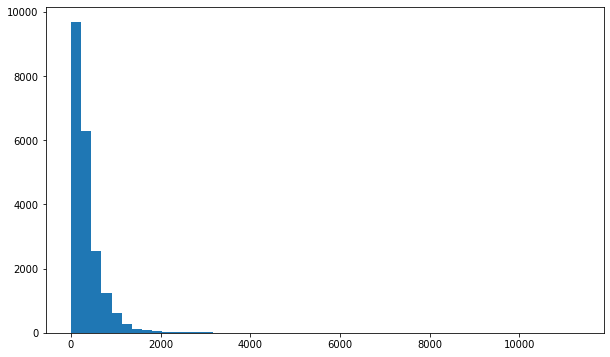

In [18]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
complaints_lens = [len(d) for d in df_clean.complaint_pos_removed]
plt.hist(complaints_lens, bins = 50)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

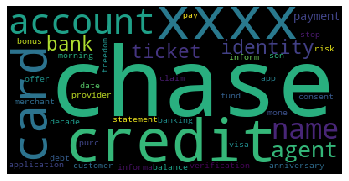

In [19]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
stoplist = set(stopwords.words("english"))

wordcloud = WordCloud(stopwords=stoplist,max_words=40).generate(str(df_clean.complaint_pos_removed))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [20]:
#Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaint_pos_removed'].str.replace('-PRON-', '')

C:\Users\balaji\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
df_clean

,complaint_what_happened,complaint_lemma,complaint_pos_removed,complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx card agent anniversary date agent informa...,xxxx card agent anniversary date agent informa...
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,application identity consent credit identity a...,application identity consent credit identity a...
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx xxxx xxxx ticket offer ticket card inform...,xxxx xxxx xxxx ticket offer ticket card inform...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade credit chase bonus ...,chase card customer decade credit chase bonus ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,xxxx xxxx visa credit card provider claim purc...,xxxx xxxx visa credit card provider claim purc...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk chase bank app chase banking merchant...,pay risk chase bank app chase banking merchant...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit chase credit chase freedom balance life...,credit chase credit chase freedom balance life...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [22]:
def get_top_n_ngram( corpus, n_gram_range ,n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [23]:
def plot_common_words(n_gram=1,n_top=30,n_gram_x='unigram'):
    common_words = get_top_n_ngram(df_clean.complaint_clean, n_gram, n_top)
    df3 = pd.DataFrame(common_words, columns = [n_gram_x , 'count'])
    plt.figure(figsize=[35,25])
    fig = sns.barplot(x=df3[n_gram_x], y=df3['count'])
    return common_words

def display_common_words(data):
    return pd.DataFrame(data).sort_values(by=1,ascending=False )[:10]

--1 [[ 6  1  1 ... 25  1  1]]


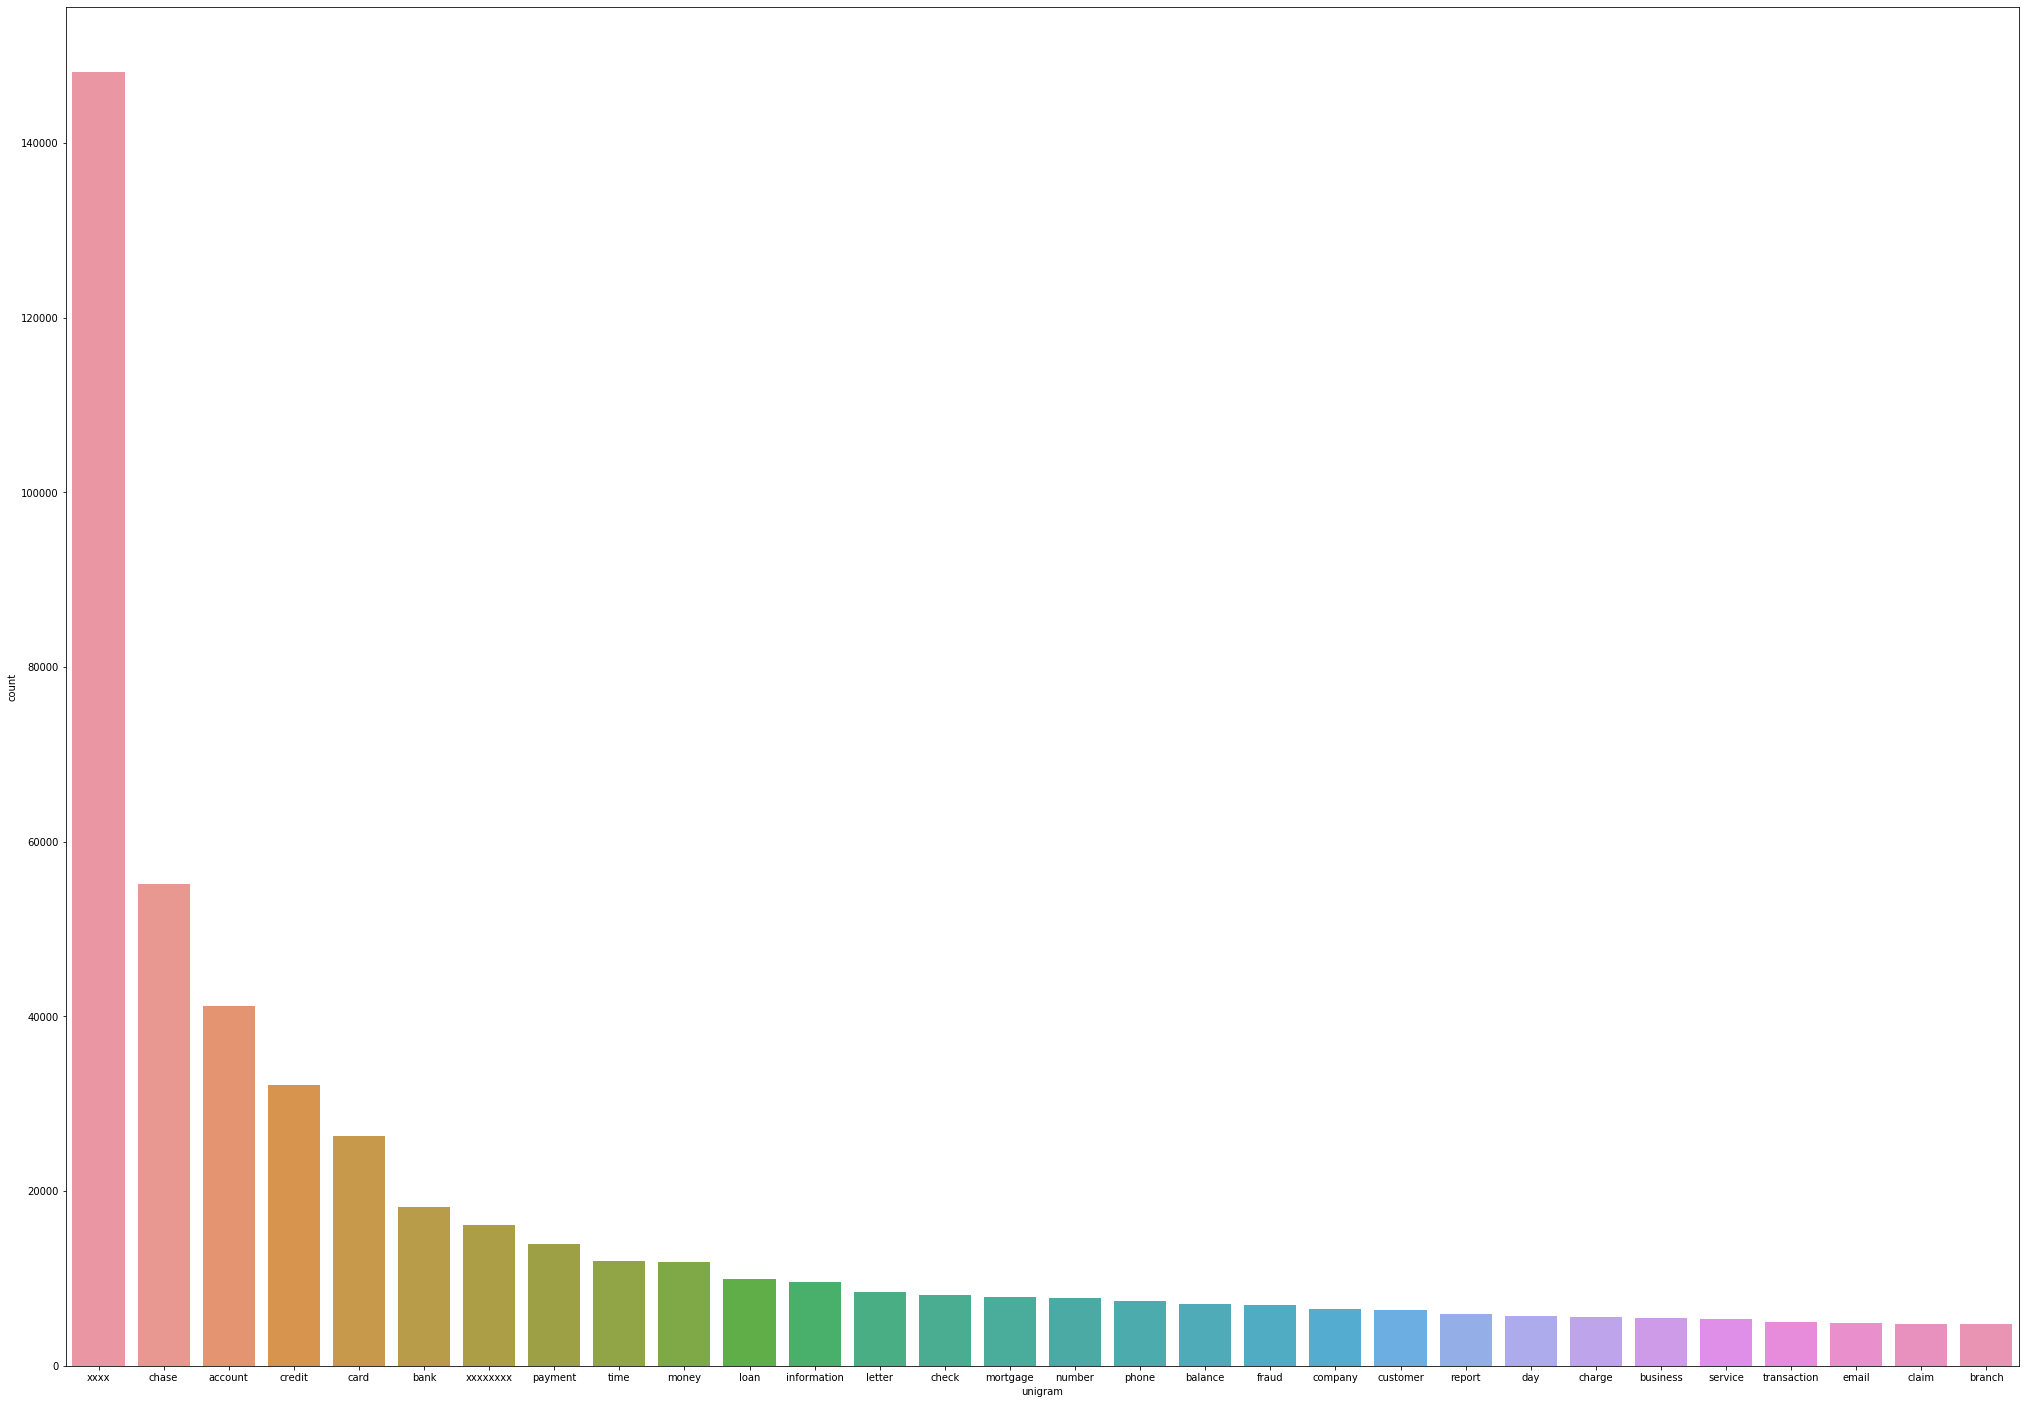

In [24]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = plot_common_words(1,30, 'unigram')

In [25]:
#Print the top 10 words in the unigram frequency
display_common_words(common_words)

,0,1
0,xxxx,148166
1,chase,55149
2,account,41146
3,credit,32157
4,card,26322
5,bank,18183
6,xxxxxxxx,16125
7,payment,13969
8,time,11960
9,money,11936


--1 [[1 2 1 ... 1 1 1]]


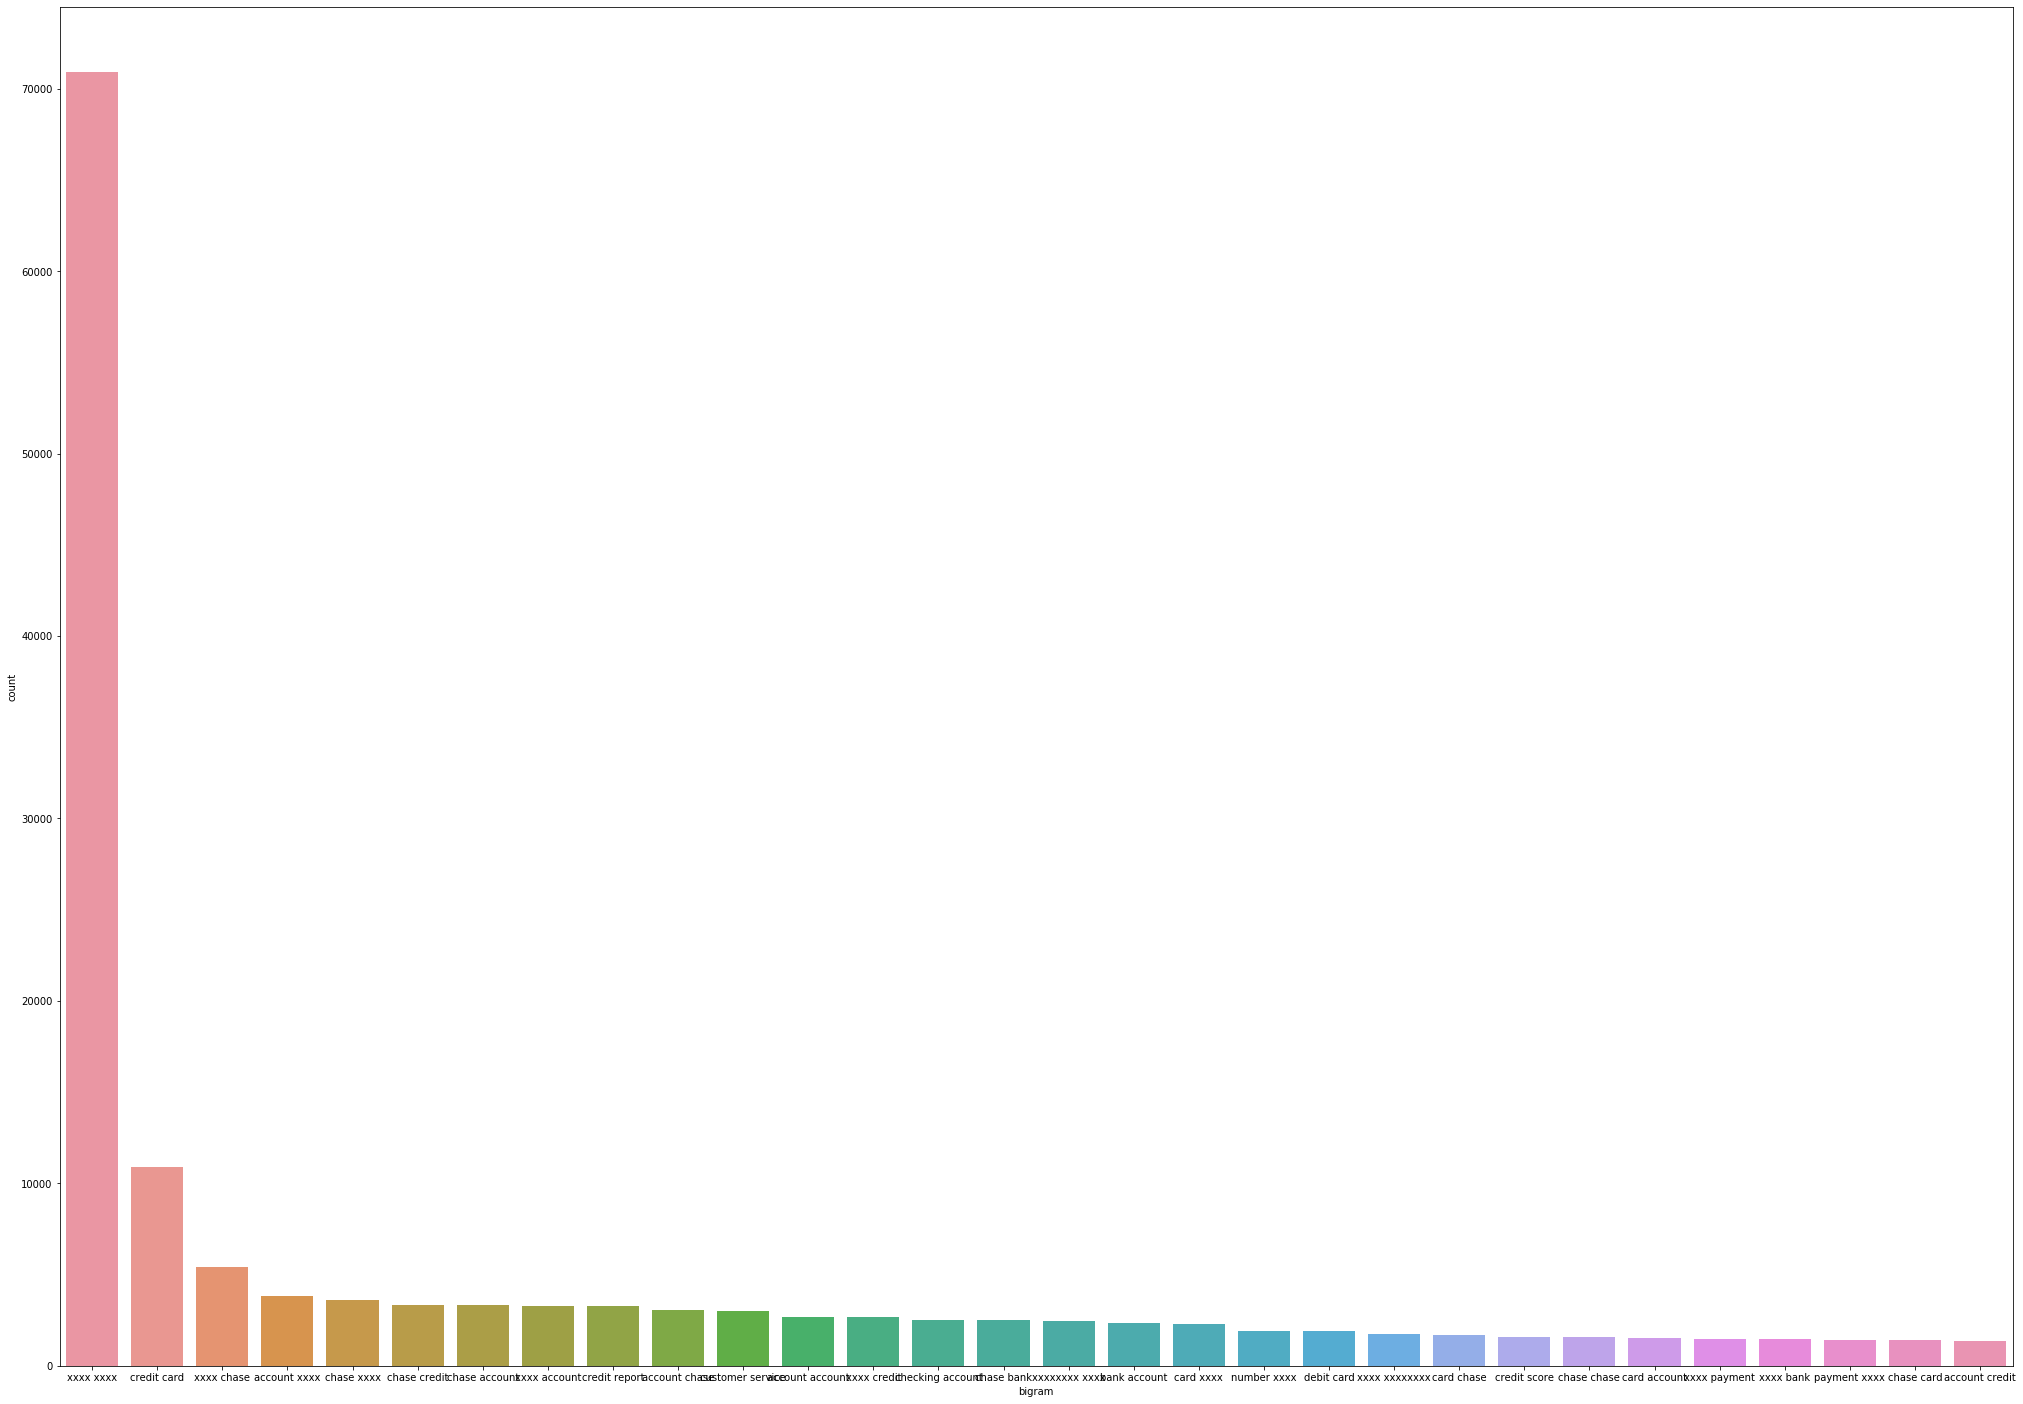

In [26]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = plot_common_words(2,30, 'bigram')

In [27]:
#Print the top 10 words in the bigram frequency
display_common_words(common_words)

,0,1
0,xxxx xxxx,70942
1,credit card,10921
2,xxxx chase,5421
3,account xxxx,3853
4,chase xxxx,3593
5,chase credit,3353
6,chase account,3314
7,xxxx account,3263
8,credit report,3258
9,account chase,3080


--1 [[1 2 1 ... 1 1 1]]


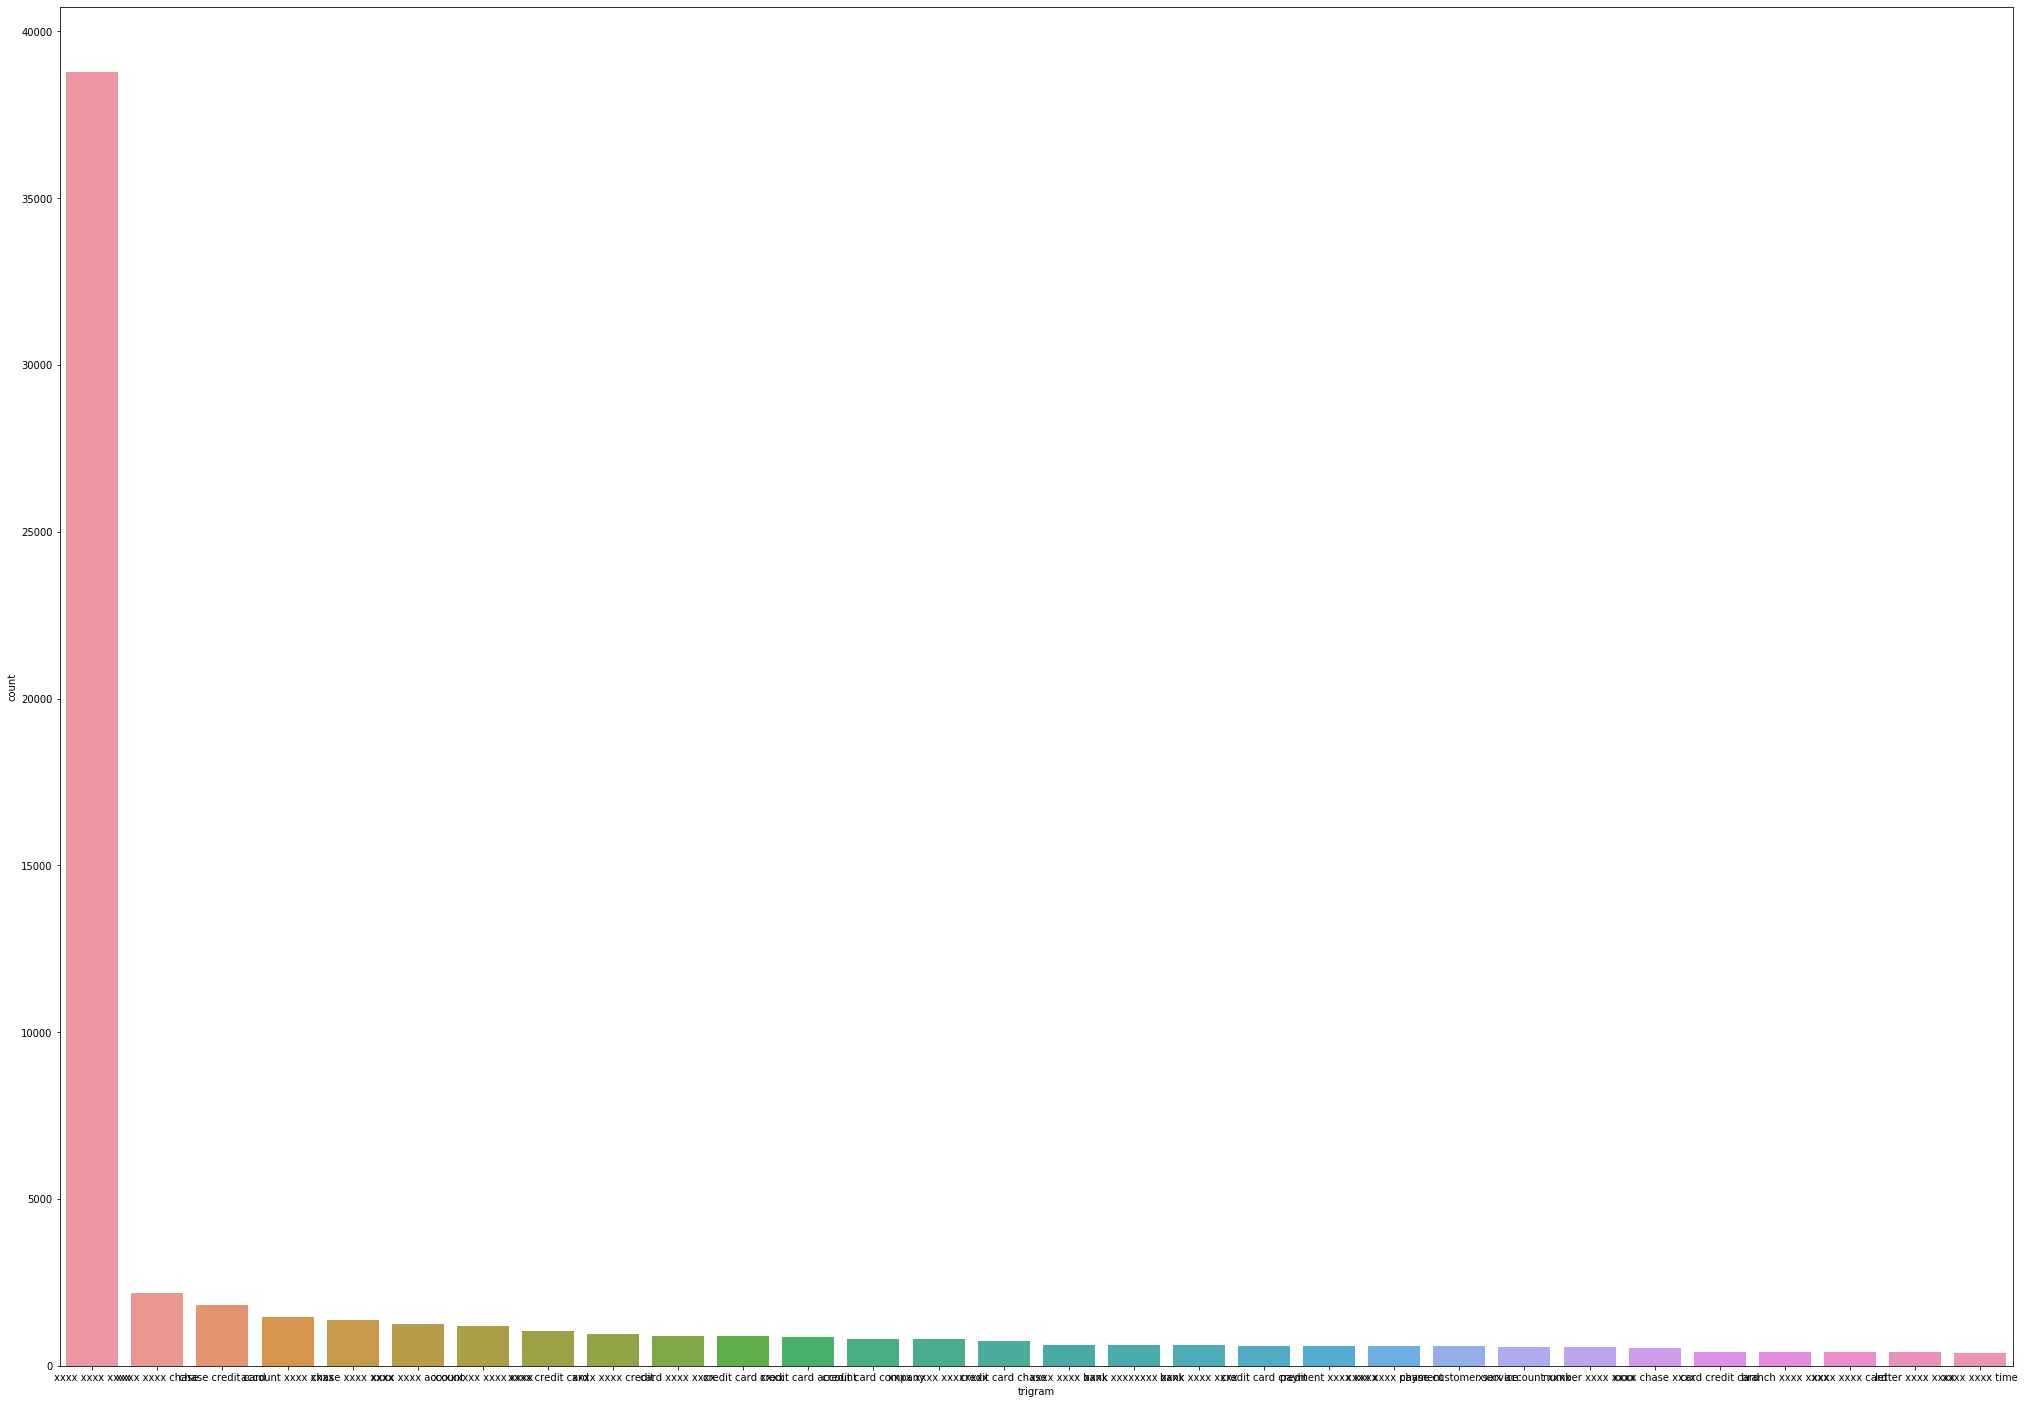

In [28]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
common_words = plot_common_words(3,30, 'trigram')

In [29]:
#Print the top 10 words in the trigram frequency
display_common_words(common_words)

,0,1
0,xxxx xxxx xxxx,38796
1,xxxx xxxx chase,2195
2,chase credit card,1829
3,account xxxx xxxx,1468
4,chase xxxx xxxx,1374
5,xxxx xxxx account,1266
6,xxxxxxxx xxxx xxxx,1205
7,xxxx credit card,1031
8,xxxx xxxx credit,953
9,card xxxx xxxx,906


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [30]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')

C:\Users\balaji\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_lemma,complaint_pos_removed,complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,application identity consent credit identity a...,application identity consent credit identity a...
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx xxxx xxxx ticket offer ticket card inform...,ticket offer ticket card information offer ...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade credit chase bonus ...,chase card customer decade credit chase bonus ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,xxxx xxxx visa credit card provider claim purc...,visa credit card provider claim purchase pro...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk chase bank app chase banking merchant...,pay risk chase bank app chase banking merchant...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit chase credit chase freedom balance life...,credit chase credit chase freedom balance life...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [32]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.95)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [33]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.complaint_clean.astype('U').values)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [34]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [35]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5  #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [36]:
W = nmf_model.fit_transform(dtm)
H = nmf_model.components_
len(tfidf.get_feature_names())

5795

In [37]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i+1}' for i in range(num_topics)],
                columns=[f'Word {i + 1}' for i in range(15)]).astype('str')

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]
topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,money,check,chase,checking,branch,deposit,number,business,fraud,transaction,claim,information,day
Topic 2,card,chase,credit,charge,fraud,dispute,company,merchant,fee,purchase,time,service,customer,letter,number
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,letter,house,time,rate,sale,information,process,escrow
Topic 4,credit,report,inquiry,score,debt,reporting,account,information,bureaus,limit,identity,theft,company,history,bureau
Topic 5,payment,balance,month,fee,statement,date,auto,time,chase,day,error,car,history,account,transfer


In [38]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: x.idxmax(), axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.011170,0.003323,0.019848,0.015343,0.012607,Topic 3
1,0.008903,0.017788,0.002194,0.000000,0.003828,Topic 2
2,0.000403,0.000000,0.003017,0.035899,0.000000,Topic 4
3,0.017781,0.024465,0.013546,0.047798,0.000954,Topic 4
4,0.063169,0.006311,0.010087,0.000000,0.000000,Topic 1
5,0.000000,0.000000,0.000000,0.044436,0.000000,Topic 4
6,0.056972,0.012029,0.007063,0.000000,0.005747,Topic 1
7,0.003201,0.005944,0.034409,0.000256,0.059782,Topic 5
8,0.029286,0.032237,0.023027,0.000000,0.008483,Topic 2
9,0.000000,0.056810,0.000000,0.129579,0.000000,Topic 4


In [39]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W.max_topic.values

C:\Users\balaji\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
df_clean.head()

,complaint_what_happened,complaint_lemma,complaint_pos_removed,complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Topic 3
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,Topic 2
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,application identity consent credit identity a...,application identity consent credit identity a...,Topic 4
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx xxxx xxxx ticket offer ticket card inform...,ticket offer ticket card information offer ...,Topic 4
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Topic 1


In [41]:
#Print the first 5 Complaint for each of the Topics
df_clean_temp=df_clean.groupby('Topic').head(5)
df_clean_temp.sort_values('Topic')

,complaint_what_happened,complaint_lemma,complaint_pos_removed,complaint_clean,Topic
27,i opened an account with chase bank on xxxx an...,opened account chase bank xxxx used code xxxx ...,account code xxxx bonus xxxxxxxx everything ac...,account code bonus everything account deposi...,Topic 1
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Topic 1
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,Topic 1
24,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,account auto xxxx,account auto,Topic 1
30,to whom it may concern chase bank charged wron...,may concern chase bank charged wrongly overdra...,concern bank overdraft alert balance fee balan...,concern bank overdraft alert balance fee balan...,Topic 1
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,Topic 2
48,jp morgan chase bank please answer the followi...,jp morgan chase bank please answer following q...,information xxxx xxxx xxxx xxxx reason informa...,information reason information chase a...,Topic 2
21,on xxxx xxxx i made a payment to an online re...,xxxx xxxx made payment online retailer using c...,xxxx xxxx payment retailer chase pay xxxx chas...,payment retailer chase pay chase website sc...,Topic 2
40,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx sofa love seat table chair never del...,xxxx xxxx sofa love seat table debit card bank...,sofa love seat table debit card bank visa cl...,Topic 2
32,my chase amazon card was declined for a cateri...,chase amazon card declined catering order plac...,chase card catering order funeral amount chase...,chase card catering order funeral amount chase...,Topic 2


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [42]:
#Create the dictionary of Topic names and Topics
Topic_names = {
    'Topic 1': 'Bank account services',
    'Topic 2': 'Credit card / Prepaid card',
    'Topic 3': 'Mortgages/loans',
    'Topic 4': 'Theft/Dispute reporting',
    'Topic 5': 'Others'   
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

C:\Users\balaji\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
df_clean

,complaint_what_happened,complaint_lemma,complaint_pos_removed,complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Mortgages/loans
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,Credit card / Prepaid card
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,application identity consent credit identity a...,application identity consent credit identity a...,Theft/Dispute reporting
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx xxxx xxxx ticket offer ticket card inform...,ticket offer ticket card information offer ...,Theft/Dispute reporting
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Bank account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade credit chase bonus ...,chase card customer decade credit chase bonus ...,Credit card / Prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,xxxx xxxx visa credit card provider claim purc...,visa credit card provider claim purchase pro...,Credit card / Prepaid card
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk chase bank app chase banking merchant...,pay risk chase bank app chase banking merchant...,Credit card / Prepaid card
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit chase credit chase freedom balance life...,credit chase credit chase freedom balance life...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [44]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    'Bank account services' : 1,
    'Credit card / Prepaid card': 2,
    'Mortgages/loans' : 3,
    'Theft/Dispute reporting': 4,
    'Others': 5   
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

C:\Users\balaji\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
df_clean

,complaint_what_happened,complaint_lemma,complaint_pos_removed,complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,3
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,2
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,application identity consent credit identity a...,application identity consent credit identity a...,4
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx xxxx xxxx ticket offer ticket card inform...,ticket offer ticket card information offer ...,4
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,1
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade credit chase bonus ...,chase card customer decade credit chase bonus ...,2
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,xxxx xxxx visa credit card provider claim purc...,visa credit card provider claim purchase pro...,2
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk chase bank app chase banking merchant...,pay risk chase bank app chase banking merchant...,2
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit chase credit chase freedom balance life...,credit chase credit chase freedom balance life...,5


In [46]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'Topic']]

In [47]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,3
2,i upgraded my xxxx xxxx card in xxxx and was t...,2
10,chase card was reported on xxxx however fraudu...,4
11,on xxxx while trying to book a xxxx xxxx tic...,4
14,my grand son give me check for i deposit it i...,1
...,...,...
78303,after being a chase card customer for well ove...,2
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,2
78310,i am not familiar with xxxx pay and did not un...,2
78311,i have had flawless credit for yrs ive had ch...,5


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [48]:
from sklearn.feature_extraction.text import TfidfTransformer

In [49]:
#Write your code to get the Vector count
count_vect = CountVectorizer()
X = count_vect.fit_transform(training_data.complaint_what_happened)

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X)

y= training_data.Topic

You have to try atleast 2 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [50]:
from sklearn import metrics
import pickle

In [51]:
def evaluate_model(y, y_pred):
    
    result_metrics = [] 
    def evaluate_scores(y, y_pred):
        accuracy = metrics.accuracy_score(y, y_pred)
        precision = metrics.precision_score(y_test, y_pred_class,average='weighted')
        recall = metrics.recall_score(y_test, y_pred_class,average='weighted')
        f1score = metrics.f1_score(y_test, y_pred_class,average='weighted')
        print("ACCURACY SCORE :", accuracy)
        print("PRECISION SCORE :", precision)
        print("RECALL SCORE :", recall)
        print("F1 SCORE :",f1score)
        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
       
    def confusion_matrix(y, y_pred):
        confusion = metrics.confusion_matrix(y_test, y_pred_class)
        #print(confusion)
        
        def plot_confusion_matrix(data, labels):
            sns.set(color_codes=True)
            plt.figure(1, figsize=(15, 9))
            plt.title("Confusion Matrix")
 
            sns.set(font_scale=1.4)
            ax = sns.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'}, fmt="")
 
            ax.set_xticklabels(labels)
            ax.set_yticklabels(labels)
 
            ax.set(ylabel="True Label", xlabel="Predicted Label")
            plt.show()
        
        # define labels
        labels = [0,1,2,3,4]
        plot_confusion_matrix(confusion,labels)
    
    evaluate_scores(y, y_pred)
    confusion_matrix(y, y_pred)
    return result_metrics

In [52]:
def train_predict_model(model, model_name, x_train, y_train, x_test):
    model.fit(x_train,y_train)
    filename = model_name+'.sav'
    pickle.dump(model, open(filename, 'wb'))
    return model.predict(x_test)

In [53]:
#y = y.values.reshape(-1,1)

In [54]:
# splitting into test and train
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, random_state=1)

In [55]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (15804, 33785)
Shape of y_train: (15804,)
Shape of X_test: (5268, 33785)
Shape of y_test: (5268,)


#### Model 1: Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class='multinomial',solver='lbfgs')

In [57]:
y_pred_class = train_predict_model(logreg,'LogisticRegression',X_train, y_train,X_test)

C:\Users\balaji\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



ACCURACY SCORE : 0.9248291571753986
PRECISION SCORE : 0.9259175835229873
RECALL SCORE : 0.9248291571753986
F1 SCORE : 0.9243233018395431


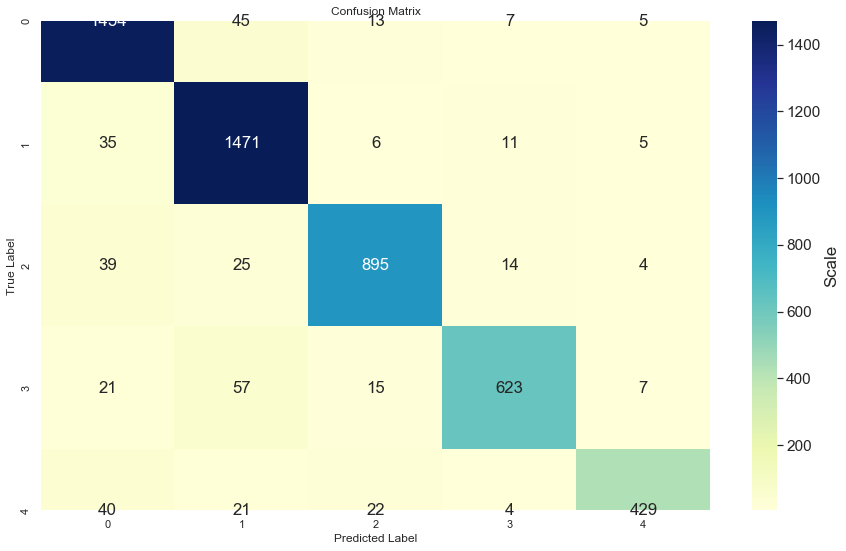

In [58]:
lr_metrics  = evaluate_model(y_test, y_pred_class)

#### Model 2: Naive Bayes

In [59]:
# Write your code here to build any 3 models and evaluate them using the required metrics
# training the NB model and making predictions
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

In [60]:
y_pred_class = train_predict_model(mnb,'NaiveBayes',X_train, y_train,X_test)

ACCURACY SCORE : 0.6524297646165528
PRECISION SCORE : 0.7371356467012824
RECALL SCORE : 0.6524297646165528
F1 SCORE : 0.5960413385776739


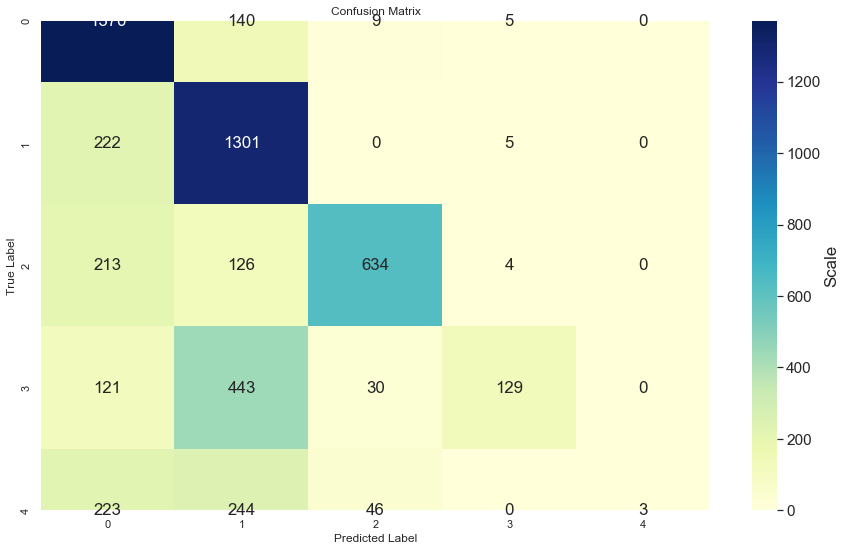

In [61]:
nb_metrics = evaluate_model(y_test, y_pred_class)

#### Model 3 - Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier

In [63]:
dt_base = DecisionTreeClassifier(random_state=42, max_depth=4)

In [64]:
y_pred_class = train_predict_model(dt_base,'DecisionTree',X_train, y_train,X_test)

ACCURACY SCORE : 0.708997722095672
PRECISION SCORE : 0.7396316650415039
RECALL SCORE : 0.708997722095672
F1 SCORE : 0.7130155387603981


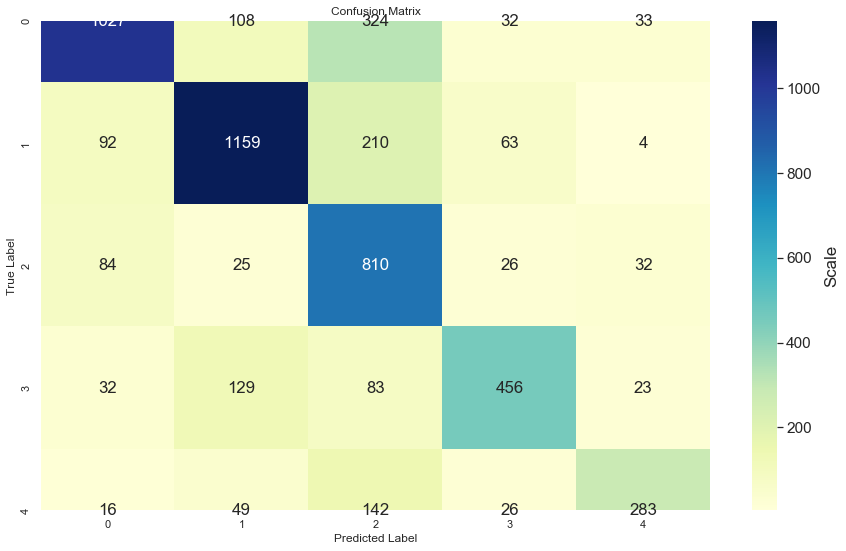

In [65]:
dt_metrics = evaluate_model(y_test, y_pred_class)

#### Model 4: Decision Tree using Grid searchCV

In [66]:
from sklearn.model_selection import GridSearchCV

In [67]:
dt = DecisionTreeClassifier(random_state=42)

In [68]:
params = {
    "max_depth": [2,3,5,10],
    "min_samples_leaf": [5,10,20,50]
}

grid_search = GridSearchCV(estimator=dt,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [69]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   31.4s finished


Wall time: 39.8 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [5, 10, 20, 50]},
             scoring='accuracy', verbose=1)

In [70]:
grid_search.best_score_

0.820361933687674

In [71]:
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=42)

In [72]:
y_pred_class = dt_best.predict(X_test)

ACCURACY SCORE : 0.8230827638572513
PRECISION SCORE : 0.8288449703488029
RECALL SCORE : 0.8230827638572513
F1 SCORE : 0.8232681846254529


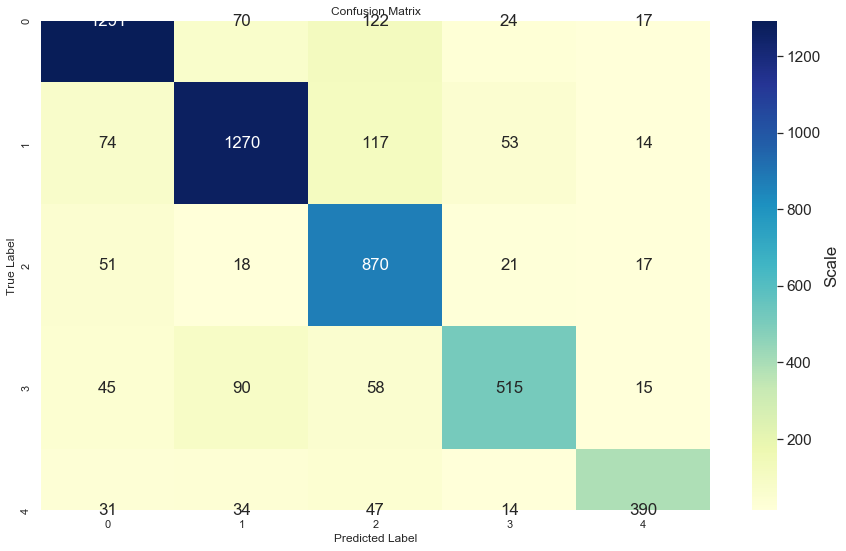

In [73]:
dt_metrics_cv = evaluate_model(y_test, y_pred_class)

#### Model 5 : Random Forrest

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [76]:
params = {
    'max_depth': [2,3,5,10,50],
    'min_samples_leaf': [5,10,20,50,100],
    'n_estimators': [10, 25, 50, 100]
}

In [77]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [78]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.7min finished


Wall time: 2min 48s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 50],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [79]:
grid_search.best_score_

0.7706276891926094

In [80]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=50, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

In [81]:
y_pred_class = rf_best.predict(X_test)

ACCURACY SCORE : 0.7877752467729688
PRECISION SCORE : 0.8060172548041066
RECALL SCORE : 0.7877752467729688
F1 SCORE : 0.7718188813302318


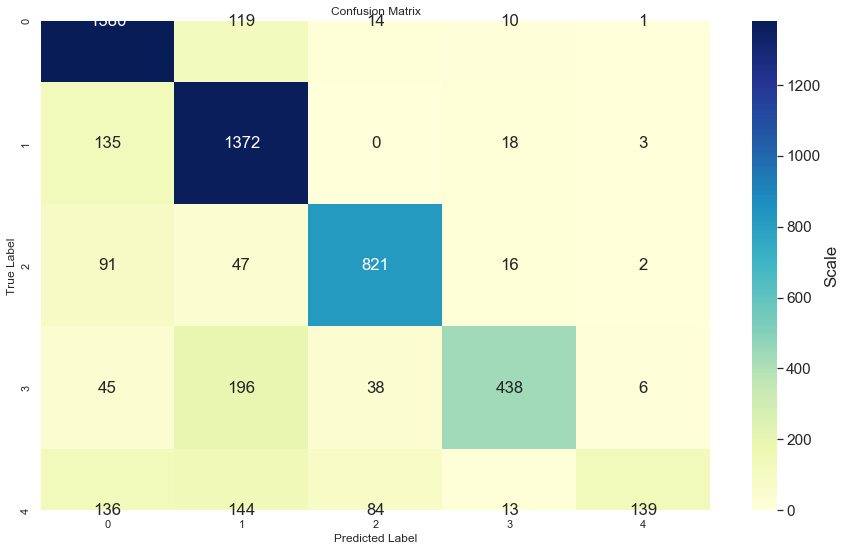

In [82]:
rf_metrics = evaluate_model(y_test, y_pred_class)

#### Model Inference

In [83]:
# Creating a table which contain all the metrics

metrics_table = {'Metric': ['Accuracy','Precision','Recall',
                       'F1Score'], 
        'Logistic Regression': lr_metrics,
        'Naive Bayes': nb_metrics,
        'Decision Tree': dt_metrics,
         'Random Forrest': rf_metrics,
        }

df_metrics = pd.DataFrame(metrics_table ,columns = ['Metric', 'Logistic Regression', 'Naive Bayes','Decision Tree','Random Forrest'] )

df_metrics



,Metric,Logistic Regression,Naive Bayes,Decision Tree,Random Forrest
0,Accuracy,0.924829,0.652430,0.708998,0.787775
1,Precision,0.925918,0.737136,0.739632,0.806017
2,Recall,0.924829,0.652430,0.708998,0.787775
3,F1Score,0.924323,0.596041,0.713016,0.771819


Logistic Regression performs better with F1 score of 92% and it performs better the other models experimented and hence choosing it as a better model

In [84]:
logreg_model = pickle.load(open('LogisticRegression.sav', 'rb'))

sample_complaint = "My Credit card is not working since yesterday. Please fix it ASAP."
vectorized = tfidf_transformer.transform(count_vect.transform([sample_complaint]))
predictions = logreg_model.predict(vectorized)

In [85]:
if len(predictions)>0:
    print([k for k, v in Topic_names.items() if v==predictions[0]])

['Credit card / Prepaid card']
